<a href="https://colab.research.google.com/github/akashbinu699/DRON/blob/main/Final_Thesis_Code_UK_Enhanced_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Information about the openrouteservice

[Link](https://readthedocs.org/projects/openrouteservice-py/downloads/pdf/latest/)

In [38]:
import time

start = time.time()

#### Import all the modules in this same kernelI that I will use later for the project

In [39]:
!pip install numpy pandas matplotlib haversine geopy folium pulp openrouteservice cplex chime

In [40]:
# Import numpy for creating the customers coordinates
import numpy as np
np.random.seed()

# Import this so I can print the full NumPy array, without truncation or missing any kind of values
import sys
np.set_printoptions(threshold=sys.maxsize)

# Import pandas for the data manipulation in the whole project
import pandas as pd
pd.options.mode.chained_assignment = None

# Import matplotlib module in order to plot the final maps
import matplotlib.pyplot as plt

# Import haversine module, in order to calculate the drones distances correctly
import haversine

# Import geopy in order to extract the addresses and other info for each location I will use in the maps
import geopy

# Import folium in order to create all the maps in this project
# If the maps cannot show in a properl way in github or in your pc, please use the nbviewer site and copy-paste the original link there
import folium
from folium.plugins import MarkerCluster

# Import the next two modules in order to solve the actual mathematical problem
import cplex
from pulp import *

# Import the modules for the openrouteservice api interaction
import openrouteservice
from openrouteservice import convert
from openrouteservice import client
import json

# Chice is a python module, which notify you when your code has run successully
import chime

### Create the initial data we will use later

In [41]:
"""
Keep in mind that in order to create the maps, you must use lat and then long coordinates in order to make the maps.
When applying the Openrouteservice API, you must, however, do the reverse of those two.

In order to give my simulation a more realistic point of view,
I will use the original coordinates of one of the largest transportation companies in Greece,
ACS in Lamia, which are listed below.
"""

#customers = 9
#hub_lat = 51.5074
#hub_long = -0.1278


"""
Create a unique dataframe which will include both the latitude and longitude for the customers we randomly create each time,
as well as the unique demands for parcel delivery for those customers each time.

The values 0.01 and 0.015 represent the two variances on the x-axis and on the y-axis that we will generate at random for our upcoming customers.
Keep in mind that changing the values to much higher values will cause problems because customers will be created outside of Lamia or in nearby mountains and fields.
"""



df = pd.DataFrame({"lat": 54.9340,
                   "long": -1.5159,
                   "demand": 0}, index=[0])  # Create DataFrame with index 0


# Add two more entries
df.loc[1] = [54.542723, -1.534555, 3]  # New entry at index 1
df.loc[2] = [54.535897, -1.533183, 2]  # New entry at index 2
df.loc[3] = [55.012553, -1.450754, 4]  # New entry at index 3
df.loc[4] = [55.003274, -1.430334, 3]  # New entry at index 4
df.loc[5] = [54.985921, -1.661928, 2]  # New entry at index 5
df.loc[6] = [54.981166, -1.609814, 1]  # New entry at index 6
df.loc[7] = [54.972907, -1.609099, 5]  # New entry at index 7
df.loc[8] = [54.960754, -1.492539, 5]  # New entry at index 8

#df.iloc[0,0] = hub_lat
##df.iloc[0,1] = hub_long
##df.iloc[0,2] = 0

In [42]:
hub_lat = 54.9340
hub_long =-1.5159
customers = 8

In [43]:
df

,lat,long,demand
0,54.934000,-1.515900,0.0
1,54.542723,-1.534555,3.0
2,54.535897,-1.533183,2.0
3,55.012553,-1.450754,4.0
4,55.003274,-1.430334,3.0
5,54.985921,-1.661928,2.0
6,54.981166,-1.609814,1.0
7,54.972907,-1.609099,5.0
8,54.960754,-1.492539,5.0


In [44]:
coordinates = df.copy()
coordinates = coordinates.drop('demand' , axis = 1)
coordinates

,lat,long
0,54.934000,-1.515900
1,54.542723,-1.534555
2,54.535897,-1.533183
3,55.012553,-1.450754
4,55.003274,-1.430334
5,54.985921,-1.661928
6,54.981166,-1.609814
7,54.972907,-1.609099
8,54.960754,-1.492539


Get the API key from openrouteservice

In [45]:
# Replace your personal API key in the key variable
# Bear in mind, that you should not share you key with anyone

client = openrouteservice.Client(key='5b3ce3597851110001cf62480269346609c64a5184f27e5a9f0c84e5')

Click here for more info about Openrouteservice and how to calculate the next matrices.

 [Link](https://openrouteservice-py.readthedocs.io/en/latest/)

### The four vehicles options we will examine are the following below:

* Driving Vars
* Driving Hgvs
* Drones
* Autonomous Vehicles

# Calculate the distance matrix for the driving-car

In [46]:
# Retrieve Distance Matrix for cars

def _driving_cars_distance_results(_df):

    # Create an empty matrix with customers x customers dimensions
    _distance_matrix_car = np.zeros((len(_df),len(_df)))
    _df['lat-long'] = '0'
    for i in range(len(_df)):
        _df['lat-long'].iloc[i] = (_df.long[i], _df.lat[i])

    for i in range(len(_df)):
        for j in range(len(_df)):
            if i == j:
                continue

            # Retrieve distances between customer nodes
            _driving_cars_distance_results = client.directions((_df['lat-long'].iloc[i], _df['lat-long'].iloc[j]), profile='driving-car')

            # Uncommnet the next line if you wish to view all the info from the request from ops
            # print(_hgv_distance_matrix_hgvs_results_json)
            _distance_matrix_car[i][j] = _driving_cars_distance_results["routes"][0]["summary"]["distance"]

    return _distance_matrix_car

distance_driving_car = _driving_cars_distance_results(df)

<ipython-input-46-6b5630ea886f>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  _df['lat-long'].iloc[i] = (_df.long[i], _df.lat[i])
<ipython-input-46-6b5630ea886f>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.

In [47]:
print("The final distance matrix for the cars: \n \n", distance_driving_car)

The final distance matrix for the cars: 
 
 [[    0.  49521.2 51409.7 16539.6 14992.9 15408.8 11539.3 10527.1  5662.8]
 [50040.6     0.   2567.1 63634.6 62087.9 61747.8 57736.8 56914.8 52757.8]
 [51943.6  3764.7     0.  65537.7 63990.9 63650.9 59639.9 58817.8 54660.8]
 [15535.2 62624.2 64512.8     0.  12249.2 15344.5 11730.4 12680.3  8693.7]
 [14233.3 61322.3 63210.8 14116.5     0.  23961.4 20092.  19079.7  7377.8]
 [15171.5 59109.1 60997.6 15370.2 22215.7     0.   4970.6  5401.  14864.1]
 [11356.6 57038.2 58926.8 11734.8 18580.2  4856.1     0.   1576.6 11049.1]
 [10850.8 56416.8 58305.3 12443.9 19857.9  5100.6  1199.4     0.  10543.4]
 [ 5480.5 52569.6 54458.1  9524.4  7962.8 15215.  11345.5 10333.3     0. ]]


# Calculate the distance matrix for the driving-hgv

In [48]:
# Retrieve Distance Matrix hgvs

def _driving_hgvs_distance_results(_df):

    # Create an empty matrix with customers x customers dimensions
    _distance_matrix_hgv = np.zeros((len(_df),len(_df)))
    _df['lat-long'] = '0'
    for i in range(len(_df)):
        _df['lat-long'].iloc[i] = (_df.long[i], _df.lat[i])

    for i in range(len(_df)):
        for j in range(len(_df)):
            if i == j:
                continue

            # Retrieve distances between customer nodes
            _driving_hgvs_distance_results = client.directions((_df['lat-long'].iloc[i], _df['lat-long'].iloc[j]), profile='driving-hgv')

            # Uncommnet the next line if you wish to view all the info from the request from ops
            # print(_hgv_distance_matrix_hgvs_results_json)
            _distance_matrix_hgv[i][j] = _driving_hgvs_distance_results["routes"][0]["summary"]["distance"]

    return _distance_matrix_hgv

distance_driving_hgv = _driving_hgvs_distance_results(df)

<ipython-input-48-bfa630f7836d>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  _df['lat-long'].iloc[i] = (_df.long[i], _df.lat[i])
<ipython-input-48-bfa630f7836d>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.

In [49]:
print("The final distance matrix for the hgvs: \n \n",distance_driving_hgv)

The final distance matrix for the hgvs: 
 
 [[    0.  49521.2 51427.2 14684.  13471.2 15401.7 11518.9 10519.9  5631.9]
 [50040.6     0.   3840.  61779.  60566.2 61747.8 58613.9 57614.9 52726.9]
 [51943.6  3764.7     0.  63682.1 62469.3 63650.9 60516.9 59518.  54629.9]
 [13514.9 60603.9 62509.9     0.  12597.9 15364.5 11750.4 13198.6  8836.1]
 [12801.1 59890.1 61796.2 14718.6     0.  22528.5 18645.7 17646.8  8122.4]
 [15165.  62254.  64160.  15376.7 22665.9     0.   4977.   5905.7 14826.6]
 [11949.4 59038.4 60944.5 11734.8 19450.4  4856.1     0.   2690.2 11611.1]
 [10837.8 57926.8 59832.9 12443.9 18338.8  5100.6  1199.4     0.  10499.5]
 [ 5480.5 52569.5 54475.6  9524.4  8311.6 15207.9 11325.1 10326.2     0. ]]


# Calculate the distance matrix for the autonomous vehicles

In [50]:
# Retrieve Distance Matrix AVs

def _cycling_electric_distance_results(_df):

    # Create an empty matrix with customers x customers dimensions
    _distance_matrix_cycling_electric = np.zeros((len(_df),len(_df)))
    _df['lat-long'] = '0'
    for i in range(len(_df)):
        _df['lat-long'].iloc[i] = (_df.long[i], _df.lat[i])

    for i in range(len(_df)):
        for j in range(len(_df)):
            if i == j:
                continue

            # Retrieve distances between customer nodes
            _cycling_electric_distance_results = client.directions((_df['lat-long'].iloc[i], _df['lat-long'].iloc[j]),profile='cycling-electric')
            _distance_matrix_cycling_electric[i][j] = _cycling_electric_distance_results["routes"][0]["summary"]["distance"]

    return _distance_matrix_cycling_electric


distance_cycling_electric = _cycling_electric_distance_results(df)

<ipython-input-50-f02cf98fa5ff>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  _df['lat-long'].iloc[i] = (_df.long[i], _df.lat[i])
<ipython-input-50-f02cf98fa5ff>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.

In [51]:
print("The final distance matrix for the autonomous vehicles: \n \n",distance_cycling_electric)

The final distance matrix for the autonomous vehicles: 
 
 [[    0.  53041.9 54423.3 16514.6 14643.5 14694.7 11552.  10378.3  6272.9]
 [54515.2     0.   1648.6 67650.4 69645.3 59377.2 56234.4 55060.7 59536.7]
 [55896.6  1648.6     0.  69031.7 75779.9 60758.5 57615.8 56442.1 60918. ]
 [16536.7 66301.9 67683.3     0.   4485.8 15977.1 11835.1 16428.2  8902.1]
 [14643.5 68301.5 75822.8  4485.8     0.  24591.7 21449.  20275.3  9134.6]
 [15329.4 58512.7 59894.  15984.9 25141.7     0.   4072.6  4911.1 15686.3]
 [11818.7 55002.  56383.3 11846.8 18566.7  4035.9     0.   1400.3 12175.5]
 [10881.7 54065.  55446.3 16851.5 20694.   4664.5  1190.      0.  11238.5]
 [ 6307.1 58205.5 59586.9  8903.7  9134.6 15086.3 11943.6 10769.9     0. ]]


# Calculate the distance matrix for the drones - Haversine Distance

In [52]:
from haversine import haversine, Unit

#Retrieve Distance Matrix Drones
def _drone_distance_results(_df):

    _travel_distance_drone = np.zeros((len(_df),len(_df)))
    _df['lat-long'] = '0'
    for i in range(len(_df)):
        _df['lat-long'].iloc[i] = (df.lat[i],df.long[i])

    for i in range(len(_df)):
        for j in range(len(_df)):
            # Calculate distances between customer nodes
            _haversine_result = haversine(_df['lat-long'].iloc[i],
                                          _df['lat-long'].iloc[j],
                                          unit='m')

            # Append distances to matrix
            _travel_distance_drone[i][j] = int(_haversine_result)

    return _travel_distance_drone

distance_drone = _drone_distance_results(df)

<ipython-input-52-3e66e6d77734>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  _df['lat-long'].iloc[i] = (df.lat[i],df.long[i])
<ipython-input-52-3e66e6d77734>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!


In [53]:
print("The final distance matrix for the drones: \n \n", distance_drone)

The final distance matrix for the drones: 
 
 [[    0. 43524. 44280.  9673.  9442. 10965.  7966.  7357.  3328.]
 [43524.     0.   764. 52518. 51645. 49954. 48991. 48072. 46561.]
 [44280.   764.     0. 53264. 52387. 50717. 49755. 48836. 47313.]
 [ 9673. 52518. 53264.     0.  1661. 13790. 10728. 11020.  6346.]
 [ 9442. 51645. 52387.  1661.     0. 14898. 11710. 11894.  6173.]
 [10965. 49954. 50717. 13790. 14898.     0.  3366.  3668. 11166.]
 [ 7966. 48991. 49755. 10728. 11710.  3366.     0.   919.  7821.]
 [ 7357. 48072. 48836. 11020. 11894.  3668.   919.     0.  7561.]
 [ 3328. 46561. 47313.  6346.  6173. 11166.  7821.  7561.     0.]]


### Show the customer distribution in the graph below

#### The black square represents the hub and the red dots represent the customer's ID and the total number of parcels assigned to them

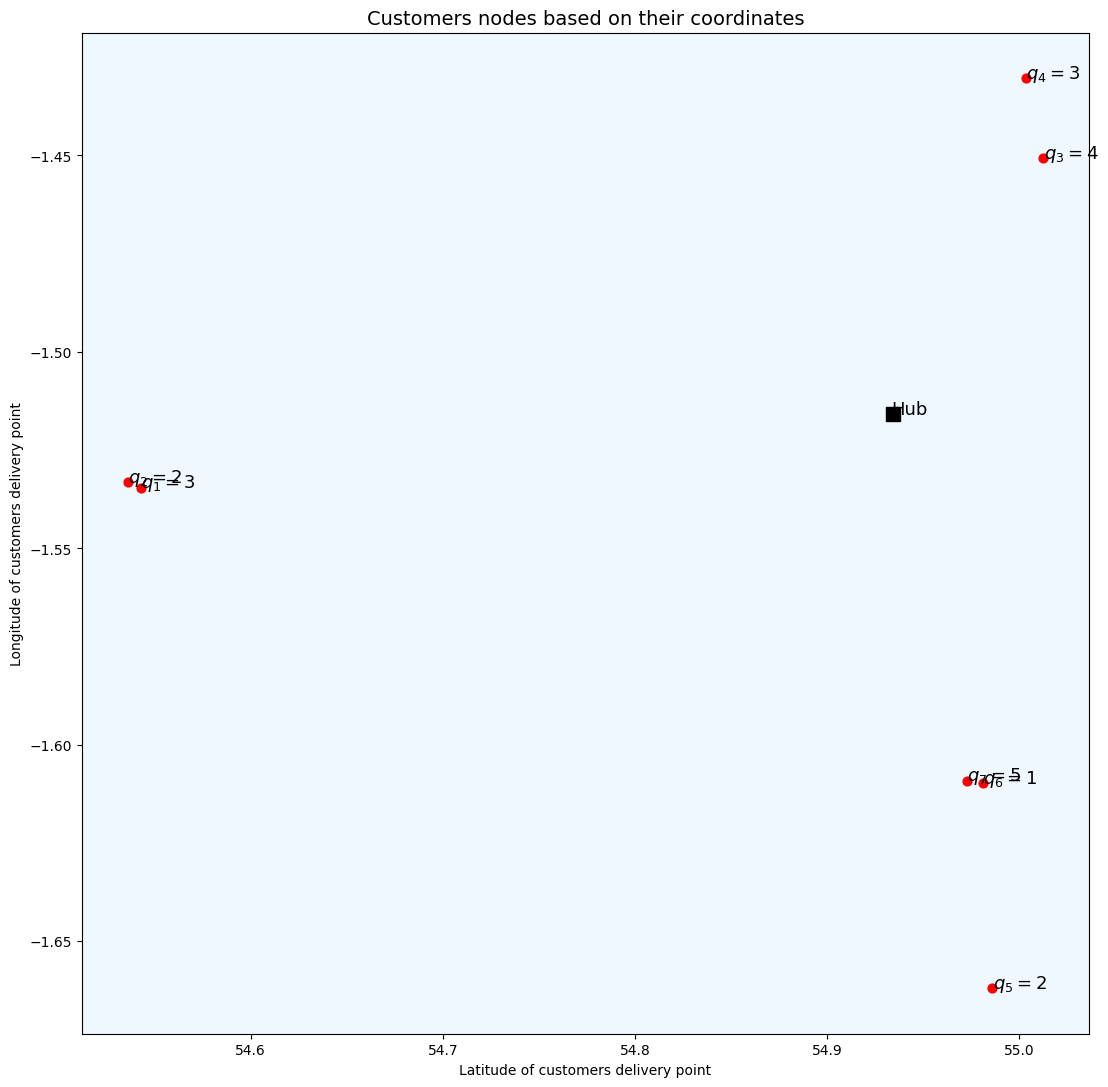

In [54]:
plt.figure(figsize=(13,13))
ax=plt.axes()
ax.set_facecolor('aliceblue')

params = {'figure.titlesize' : 20, 'axes.titlesize': 14}
plt.rcParams.update(params)

#Set the names of the axes and the title of the graph

plt.title('Customers nodes based on their coordinates')
plt.xlabel('Latitude of customers delivery point')
plt.ylabel('Longitude of customers delivery point')


for i in range(customers):
    if i == 0:
        plt.scatter(df.lat[i], df.long[i], marker='s', c='black', s=100)
        plt.text(df.lat[i] -0.00080, df.long[i], "Hub", fontsize=13)
    else:
        plt.scatter(df.lat[i], df.long[i], c='red', s=40)
        plt.text((df.lat[i]+0.0001), df.long[i], ('$q_%d=%d$'%((i,df.demand[i]))),
                 fontsize=13)

# MAPS SECTION

* create a initial map with the road names and the neighboourhood names
ie. road_names_map , neighboourhood_names_map

    and then use it, in order to diplay the cars and drones trips. From this point I will be able to double the maps I have, If I just change the initial map I use it's time.

Create the generic map for the customers coordinates of our choosen town

All info can be found in the [Link](https://towardsdatascience.com/creating-a-simple-map-with-folium-and-python-4c083abfff94)

In [55]:
# If you wish to drag the map set dragging = True

initial_map = folium.Map(location=[df.lat.mean(),
                                    df.long.mean()],
                                    zoom_start=14,
                                    zoom_control=False,
                                    scrollWheelZoom=True,
                                    dragging=True,
                                    control_scale=True
                                    )

In [56]:
# Generate and plot pop-up markers that correspond to our clients' coordinates

for index, location_info in df.iterrows():
    folium.Marker([location_info["lat"], location_info["long"]],).add_to(initial_map)

initial_map

Apply the reverse geolocator to transform our initial coordinates into more practical

More info in the [Link](https://github.com/vishal-verma27/Python_Reverse_GeoCoding/blob/Main_Copy/ReverseGeoCodingFunction.ipynb)

In [57]:
from geopy.point import Point
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="thesis")

In [58]:
coordinates[['Country','State','Municipality','City', 'City District','Neighbourhood','Road','Postcode']] = ''
coordinates

,lat,long,Country,State,Municipality,City,City District,Neighbourhood,Road,Postcode
0,54.934000,-1.515900,,,,,,,,
1,54.542723,-1.534555,,,,,,,,
2,54.535897,-1.533183,,,,,,,,
3,55.012553,-1.450754,,,,,,,,
4,55.003274,-1.430334,,,,,,,,
5,54.985921,-1.661928,,,,,,,,
6,54.981166,-1.609814,,,,,,,,
7,54.972907,-1.609099,,,,,,,,
8,54.960754,-1.492539,,,,,,,,


In [59]:
def ReverseGeoCode(coordinates):

    print("----------- Transform coordinates into more understandable data -----------")

    for i in range(0,len(coordinates)):

        coord = Point(coordinates.iloc[i,0],coordinates.iloc[i,1])
        location = geolocator.reverse(coord, exactly_one=True, addressdetails=True)
        address = location.raw['address']
        coordinates.iloc[i,2]  = address.get('country', '')
        coordinates.iloc[i,3]  = address.get('state_district', '')
        coordinates.iloc[i,4]  = address.get('municipality', '')
        coordinates.iloc[i,4]  = address.get('city', '')
        coordinates.iloc[i,6]  = address.get('city_district', '')
        coordinates.iloc[i,7]  = address.get('neighbourhood', '')
        coordinates.iloc[i,8]  = address.get('road', '')
        coordinates.iloc[i,9]  = address.get('postcode', '')


# execute the function
ReverseGeoCode(coordinates)

coordinates

----------- Transform coordinates into more understandable data -----------


,lat,long,Country,State,Municipality,City,City District,Neighbourhood,Road,Postcode
0,54.934000,-1.515900,United Kingdom,North East,,,,,North Entrance,NE10 8YX
1,54.542723,-1.534555,United Kingdom,Tees Valley,,,,,Mendip Grove,DL1 2FQ
2,54.535897,-1.533183,United Kingdom,Tees Valley,,,,,Sussex Way,DL1 2LQ
3,55.012553,-1.450754,United Kingdom,North East,North Tyneside,,,,Waterloo Place,NE29 0NA
4,55.003274,-1.430334,United Kingdom,North East,South Tyneside,,,,Trajan Street,NE33 2AW
5,54.985921,-1.661928,United Kingdom,North East,Newcastle upon Tyne,,,,Alder Avenue,NE4 9TE
6,54.981166,-1.609814,United Kingdom,North East,Newcastle upon Tyne,,,,Alley Number 2,NE1 5AW
7,54.972907,-1.609099,United Kingdom,North East,Newcastle upon Tyne,,,,Worswick Street,NE1 6XA
8,54.960754,-1.492539,United Kingdom,North East,South Tyneside,,,,Coupland Grove,NE32 5YQ


In [60]:
df

,lat,long,demand,lat-long
0,54.934000,-1.515900,0.0,"(54.934, -1.5159)"
1,54.542723,-1.534555,3.0,"(54.542723, -1.534555)"
2,54.535897,-1.533183,2.0,"(54.535897, -1.533183)"
3,55.012553,-1.450754,4.0,"(55.012553, -1.450754)"
4,55.003274,-1.430334,3.0,"(55.003274, -1.430334)"
5,54.985921,-1.661928,2.0,"(54.985921, -1.661928)"
6,54.981166,-1.609814,1.0,"(54.981166, -1.609814)"
7,54.972907,-1.609099,5.0,"(54.972907, -1.609099)"
8,54.960754,-1.492539,5.0,"(54.960754, -1.492539)"


In [61]:
def ReverseGeoCode(df):
    # add additional columns for country, state, city, postcode, and suburb

    df[['Country','State','Municipality','City', 'City District','Neighbourhood','Road','Postcode']] = ''
    print("----------- Conversion Started -----------")

    for i in range(0,len(df)):

        coord = Point(df.iloc[i,0],df.iloc[i,1])
        location = geolocator.reverse(coord, exactly_one=True, addressdetails=True)
        address = location.raw['address']
        df.iloc[i,4]  = address.get('country', '')
        df.iloc[i,4]  = address.get('state_district', '')
        df.iloc[i,6]  = address.get('municipality', '')
        df.iloc[i,7]  = address.get('city', '')
        df.iloc[i,8]  = address.get('city_district', '')
        df.iloc[i,9]  = address.get('neighbourhood', '')
        df.iloc[i,10]  = address.get('road', '')
        df.iloc[i,11]  = address.get('postcode', '')


# execute the function
ReverseGeoCode(df)

df

----------- Conversion Started -----------


,lat,long,demand,lat-long,Country,State,Municipality,City,City District,Neighbourhood,Road,Postcode
0,54.934000,-1.515900,0.0,"(54.934, -1.5159)",North East,,,,,,North Entrance,NE10 8YX
1,54.542723,-1.534555,3.0,"(54.542723, -1.534555)",Tees Valley,,,,,,Mendip Grove,DL1 2FQ
2,54.535897,-1.533183,2.0,"(54.535897, -1.533183)",Tees Valley,,,,,,Sussex Way,DL1 2LQ
3,55.012553,-1.450754,4.0,"(55.012553, -1.450754)",North East,,,North Tyneside,,,Waterloo Place,NE29 0NA
4,55.003274,-1.430334,3.0,"(55.003274, -1.430334)",North East,,,South Tyneside,,,Trajan Street,NE33 2AW
5,54.985921,-1.661928,2.0,"(54.985921, -1.661928)",North East,,,Newcastle upon Tyne,,,Alder Avenue,NE4 9TE
6,54.981166,-1.609814,1.0,"(54.981166, -1.609814)",North East,,,Newcastle upon Tyne,,,Alley Number 2,NE1 5AW
7,54.972907,-1.609099,5.0,"(54.972907, -1.609099)",North East,,,Newcastle upon Tyne,,,Worswick Street,NE1 6XA
8,54.960754,-1.492539,5.0,"(54.960754, -1.492539)",North East,,,South Tyneside,,,Coupland Grove,NE32 5YQ


In [62]:
# Shows all the info we can extract  for each of the coordiantions - in progress

geolocator = Nominatim(user_agent="diplwmatikh")

def ReverseGeoCode(df):

    for i in range(0,1):

        coord = Point(df.iloc[i,0],df.iloc[i,1])
        location = geolocator.reverse(coord, exactly_one=True, addressdetails=True)
        address = location.raw['address']

    return address

# execute the function
ReverseGeoCode(df)

{'road': 'North Entrance',
 'industrial': 'Amazon Gateshead',
 'town': 'Gateshead',
 'ISO3166-2-lvl8': 'GB-GAT',
 'county': 'Tyne and Wear',
 'state_district': 'North East',
 'state': 'England',
 'ISO3166-2-lvl4': 'GB-ENG',
 'postcode': 'NE10 8YX',
 'country': 'United Kingdom',
 'country_code': 'gb'}

Cluster the customers by their locations

More info in the [Link](https://towardsdatascience.com/pythons-geocoding-convert-a-list-of-addresses-into-a-map-f422ef413fd6)

In [63]:
 # the (lat, long) of our hub

hub_locations = float(hub_lat), float(hub_long)

In [64]:
marker_cluster = MarkerCluster().add_to(initial_map)

# Add the markers the the cluster layers so that they are automatically clustered

for i,r in df.iterrows():
    location = (r["lat"], r["long"])
    folium.Marker(location=location).add_to(marker_cluster)


# display the map with clusters
initial_map

In [65]:
# Sometimes ORS cannot locate the correct name of the same addresses, in which case the popup marker will display the phrase "Unkown Address"

df['Road'] = df['Road'].replace('', 'Unkown Address', regex=True)
df['Road']

,Road
0,North Entrance
1,Mendip Grove
2,Sussex Way
3,Waterloo Place
4,Trajan Street
5,Alder Avenue
6,Alley Number 2
7,Worswick Street
8,Coupland Grove


In [66]:
def create_map_markers(df, map_name):
    folium.Marker(location=[df['lat'], df['long']], popup=df['Road']).add_to(initial_map)

In [67]:
# Before we apply this function to our dataframe, we’re going to drop any locations that were “Not Found” (which would cause folium.Marker() to return an error)
# It differs from the kernel mentioned above

road_names = df[df['Road'] != "Not Found"]

road_names.apply(create_map_markers, map_name=map, axis='columns')
initial_map

* circle map will show the region in which each customer belongs

In [68]:
circle_map = folium.Map(location=[df.lat.mean(), df.long.mean()],
                                            zoom_start=14,
                                            zoom_control=False,
                                            scrollWheelZoom=True,
                                            dragging=True,
                                            control_scale=True
                                            )

In [69]:
def create_circle_map_markers(row, map_name):

    folium.CircleMarker(location=[row['lat'], row['long']], raidus=100, fill=True,
                        popup=folium.Popup(f"{row['Neighbourhood']}")
                        ).add_to(circle_map)

df.apply(create_circle_map_markers,map_name=circle_map, axis="columns")

print("In the map below you are able to view the neighbourhood each of the customers belongs")

circle_map

In the map below you are able to view the neighbourhood each of the customers belongs


In [70]:
initial_loc = [hub_long,hub_lat]

In [71]:
df['long_lat'] = ""

for i in range(len(df)):
    df['long_lat'][i] = ([df.long[i], df.lat[i]])


df

<ipython-input-71-ef8290a42553>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['long_lat'][i] = ([df.long[i], df.lat[i]])
<ipython-input-71-ef8290a42553>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You

,lat,long,demand,lat-long,Country,State,Municipality,City,City District,Neighbourhood,Road,Postcode,long_lat
0,54.934000,-1.515900,0.0,"(54.934, -1.5159)",North East,,,,,,North Entrance,NE10 8YX,"[-1.5159, 54.934]"
1,54.542723,-1.534555,3.0,"(54.542723, -1.534555)",Tees Valley,,,,,,Mendip Grove,DL1 2FQ,"[-1.534555, 54.542723]"
2,54.535897,-1.533183,2.0,"(54.535897, -1.533183)",Tees Valley,,,,,,Sussex Way,DL1 2LQ,"[-1.533183, 54.535897]"
3,55.012553,-1.450754,4.0,"(55.012553, -1.450754)",North East,,,North Tyneside,,,Waterloo Place,NE29 0NA,"[-1.450754, 55.012553]"
4,55.003274,-1.430334,3.0,"(55.003274, -1.430334)",North East,,,South Tyneside,,,Trajan Street,NE33 2AW,"[-1.430334, 55.003274]"
5,54.985921,-1.661928,2.0,"(54.985921, -1.661928)",North East,,,Newcastle upon Tyne,,,Alder Avenue,NE4 9TE,"[-1.661928, 54.985921]"
6,54.981166,-1.609814,1.0,"(54.981166, -1.609814)",North East,,,Newcastle upon Tyne,,,Alley Number 2,NE1 5AW,"[-1.609814, 54.981166]"
7,54.972907,-1.609099,5.0,"(54.972907, -1.609099)",North East,,,Newcastle upon Tyne,,,Worswick Street,NE1 6XA,"[-1.609099, 54.972907]"
8,54.960754,-1.492539,5.0,"(54.960754, -1.492539)",North East,,,South Tyneside,,,Coupland Grove,NE32 5YQ,"[-1.492539, 54.960754]"


# Create the map for the hgvs trips only - Minimum distance by Openrouteservice

In [72]:
hgv_map = folium.Map(location=[df.lat.mean(), df.long.mean()],
                                            zoom_start=14,
                                            zoom_control=False,
                                            scrollWheelZoom=True,
                                            dragging=True,
                                            control_scale=True
                                            )

for index, location_info in df.iterrows():
    folium.Marker([location_info["lat"], location_info["long"]],).add_to(hgv_map)


marker_cluster = MarkerCluster().add_to(hgv_map)

for i,r in df.iterrows():
    location = (r["lat"], r["long"])
    folium.Marker(location=location).add_to(marker_cluster)


def create_map_markers(df, map_name):
    folium.Marker(location=[df['lat'], df['long']], popup=df['Road']).add_to(hgv_map)


road_names = df[df['Road'] != "Not Found"]

road_names.apply(create_map_markers, map_name=map, axis='columns')


hgv_map

In [73]:
for i in range(customers):
    coordinates  = [ initial_loc , df['long_lat'][i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-hgv',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']]).add_to(hgv_map)

hgv_map

The above map in a diferent perspective

In [74]:
hgv_map_2 = folium.Map(location=[hub_lat,hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(customers):
    coordinates  = [ initial_loc , df['long_lat'][i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-hgv',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']]).add_to(hgv_map_2)

hgv_map_2

/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rat

# Create the map for the cars trips only - Minimum distance by Openrouteservice

In [75]:
car_map = folium.Map(location=[df.lat.mean(), df.long.mean()],
                                            zoom_start=14,
                                            zoom_control=False,
                                            scrollWheelZoom=True,
                                            dragging=True,
                                            control_scale=True
                                            )

for index, location_info in df.iterrows():
    folium.Marker([location_info["lat"], location_info["long"]],).add_to(car_map)


marker_cluster = MarkerCluster().add_to(car_map)

for i,r in df.iterrows():
    location = (r["lat"], r["long"])
    folium.Marker(location=location).add_to(marker_cluster)


def create_map_markers(df, map_name):
    folium.Marker(location=[df['lat'], df['long']], popup=df['Road']).add_to(car_map)


road_names = df[df['Road'] != "Not Found"]

road_names.apply(create_map_markers, map_name=map, axis='columns')


car_map

In [76]:
for i in range(customers):
    coordinates  = [ initial_loc , df['long_lat'][i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-car',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']]).add_to(car_map)

car_map

In [77]:
car_map_2 = folium.Map(location=[hub_lat,hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(customers):
    coordinates  = [ initial_loc , df['long_lat'][i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-car',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']]).add_to(car_map_2)

car_map_2

# Create the map for the electric-bike trips only - Minimum distance by Openrouteservice

In [78]:
cycling_electric_map = folium.Map(location=[df.lat.mean(), df.long.mean()],
                                            zoom_start=14,
                                            zoom_control=False,
                                            scrollWheelZoom=True,
                                            dragging=True,
                                            control_scale=True
                                            )

for index, location_info in df.iterrows():
    folium.Marker([location_info["lat"], location_info["long"]],).add_to(cycling_electric_map)


marker_cluster = MarkerCluster().add_to(cycling_electric_map)

for i,r in df.iterrows():
    location = (r["lat"], r["long"])
    folium.Marker(location=location).add_to(marker_cluster)


def create_map_markers(df, map_name):
    folium.Marker(location=[df['lat'], df['long']], popup=df['Road']).add_to(cycling_electric_map)


road_names = df[df['Road'] != "Not Found"]

road_names.apply(create_map_markers, map_name=map, axis='columns')


cycling_electric_map

In [79]:
for i in range(customers):
    coordinates  = [ initial_loc , df['long_lat'][i]]

    route = client.directions(
        coordinates=coordinates,
        profile='cycling-electric',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']]).add_to(cycling_electric_map)

cycling_electric_map

/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 8th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,


In [80]:
cycling_electric_map_2 = folium.Map(location=[hub_lat,hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(customers):
    coordinates  = [ initial_loc , df['long_lat'][i]]

    route = client.directions(
        coordinates=coordinates,
        profile='cycling-electric',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']]).add_to(cycling_electric_map_2)

cycling_electric_map_2

## Generate the drone trip map without using Openrouteservice

### Because of the curvature of Earth, delivery routes should only be straight lines, and you must only utilize the harvesine as a measure of distance

In [81]:
drones_map = folium.Map(location=[df.lat.mean(), df.long.mean()],
                                            zoom_start=14,
                                            zoom_control=False,
                                            scrollWheelZoom=True,
                                            dragging=True,
                                            control_scale=True
                                            )

for index, location_info in df.iterrows():
    folium.Marker([location_info["lat"], location_info["long"]],).add_to(drones_map)


marker_cluster = MarkerCluster().add_to(drones_map)

# Draw the markers and assign popup and hover texts
# Add the markers the the cluster layers so that they are automatically clustered

for i,r in df.iterrows():
    location = (r["lat"], r["long"])
    folium.Marker(location=location).add_to(marker_cluster)


def create_map_markers(df, map_name):
    folium.Marker(location=[df['lat'], df['long']], popup=df['Road']).add_to(drones_map)


road_names = df[df['Road'] != "Not Found"]

road_names.apply(create_map_markers, map_name=map, axis='columns')


drones_map

In [82]:
drones_travels = []

for i in range(customers):
    drones_travels.append([(hub_lat,hub_long), (df['lat'].iloc[i], df['long'].iloc[i])])
    folium.PolyLine(drones_travels).add_to(drones_map)

print("Here you can see all the distances the drone have to go")

"""
The PolyLine distances takes two arguments as inputs (start, end)
start = (start_lat, start_long)
end = (end_lat, end_long)
"""

for i in range(customers):

    # add line between points
    folium.PolyLine(drones_travels).add_to(drones_map)

drones_map

Here you can see all the distances the drone have to go


In [83]:
drones_map_2 = folium.Map(location=[hub_lat,hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(customers):
    coordinates  = [ initial_loc , df['long_lat'][i]]

    # add line between points
    folium.PolyLine(drones_travels).add_to(drones_map_2)

drones_map_2

# Solving the actual mathematical problem

* With the original values of our parameter, the graph below would be empty if there were no real solution to solve the challenge
* The average capacity of a drone is more less 3-4 kg and the average capacity of a autonomous vehicles it depends in many variable but it is around 10-34 kg up to maximum of 40
* In each simulation I use different initial values

## CARS VS DRONES

In [84]:
car_vehicles_test_4 = 4
car_vehicles_capacity_test_4 = 30
fixed_cost_car_vehicles_test_4 = 4

drone_vehicle_test_4 = 3
drone_capacity_test_4 = 4


for car_vehicles_test_4 in range(1,car_vehicles_test_4+1):

    prob = LpProblem("VRPD", LpMinimize)

    # Define decision variables for car_vehicles_test_4 and drone
    xt = [[[LpVariable("xt%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None
            for k in range(car_vehicles_test_4)]for j in range(customers)] for i in range(customers)]

    xd = [[[LpVariable("xd%s_%s,%s"%(i,j,kd), cat="Binary") if i != j else None
            for kd in range(drone_vehicle_test_4)]for j in range(customers)] for i in range(customers)]

    # Objective function - Minimize total travel cost
    prob += lpSum((distance_driving_car[i][j] * xt[i][j][k]) if i != j else 0
                        for k in range(car_vehicles_test_4)
                        for j in range(customers)
                        for i in range (customers)) + lpSum((fixed_cost_car_vehicles_test_4 * xt[0][j][k])
                                                            for k in range(car_vehicles_test_4)
                                                            for j in range(1,customers)) + lpSum((distance_drone[i][j] * xd[i][j][kd] if i!=j else 0
                                                                                                  for kd in range(drone_vehicle_test_4)
                                                                                                  for j in range(customers)
                                                                                                  for i in range(customers)))


    # Constraint 1 - Customer is only served once by only one vehicle
    for j in range(1, customers):
        prob += lpSum(xt[i][j][k] if i != j else 0
                      for i in range(customers)
                      for k in range(car_vehicles_test_4)) + lpSum(xd[i][j][kd] if i != j else 0
                                                      for i in range(customers)
                                                      for kd in range(drone_vehicle_test_4)) == 1


    # Constraint 2 - Vehicle must depart from and return to depot
    for k in range(car_vehicles_test_4):
        prob += lpSum(xt[0][j][k] for j in range(1,customers)) == 1
        prob += lpSum(xt[i][0][k] for i in range(1,customers)) == 1


    for kd in range(drone_vehicle_test_4):
        prob += lpSum(xd[0][j][kd] for j in range(1,customers)) == 1
        prob += lpSum(xd[i][0][kd] for i in range(1,customers)) == 1


    # Constraint 3 - Only one vehicle enters and leaves each customer location
    for k in range(car_vehicles_test_4):
        for kd in range(drone_vehicle_test_4):
            for j in range(customers):
                prob += (lpSum(xt[i][j][k] if i != j else 0
                               for i in range(customers)) + lpSum(xd[i][j][kd] if i!=j else 0
                                                                  for i in range(customers))) - (lpSum(xt[j][i][k]
                                                                                                       for i in range(customers)) + lpSum(xd[j][i][kd]
                                                                                                                                          for i in range(customers))) == 0


    # Constraint 4 - Demand must not exceed vehicle capacity
    for k in range(car_vehicles_test_4):
        prob += lpSum(df.demand[j] * xt[i][j][k] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= car_vehicles_capacity_test_4

    for kd in range(drone_vehicle_test_4):
        prob += lpSum(df.demand[j] * xd[i][j][kd] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= drone_capacity_test_4


    # Constraint 4 - Subtour elimination
    subtours = []
    for i in range(2,customers):
        subtours += itertools.combinations(range(1,customers), i)


    for s in subtours:
        prob += lpSum(xt[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for k in range(car_vehicles_test_4)) <= len(s) - 1


    for s in subtours:
        prob += lpSum(xd[i][j][kd] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for kd in range(drone_vehicle_test_4)) <= len(s) - 1


    if prob.solve(CPLEX_PY()) == 1:
        prob.writeLP("VRPDModel.lp")

    for v in prob.variables():

        print(v.name, "=", v.varValue)
        print('Status:', LpStatus[prob.status],"\n")
        print(f"In order to solve the VRPD Problem, we will use", (car_vehicles_test_4) ,"Cars")
        print(f"In order to solve the VRPD Problem, we will use" , (drone_vehicle_test_4) ,"Drones")
        print('Total distance we will have to travel is: ', pulp.value(prob.objective),"\n")

        break

Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 92 rows and 39 columns.
MIP Presolve modified 162 coefficients.
Reduced MIP has 188 rows, 185 columns, and 2664 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (5.35 ticks)
Found incumbent of value 270716.400000 after 0.06 sec. (7.49 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.01 sec. (2.64 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 11 rows and 30 columns.
MIP Presolve modified 25 coefficients.
Reduced MIP has 177 rows, 155 columns, and 2322 nonzeros.
Reduced MIP has 155 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.71 ticks)
Probing time = 0.00 sec. (1.83 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1 rows and 0 columns.
Reduced MI

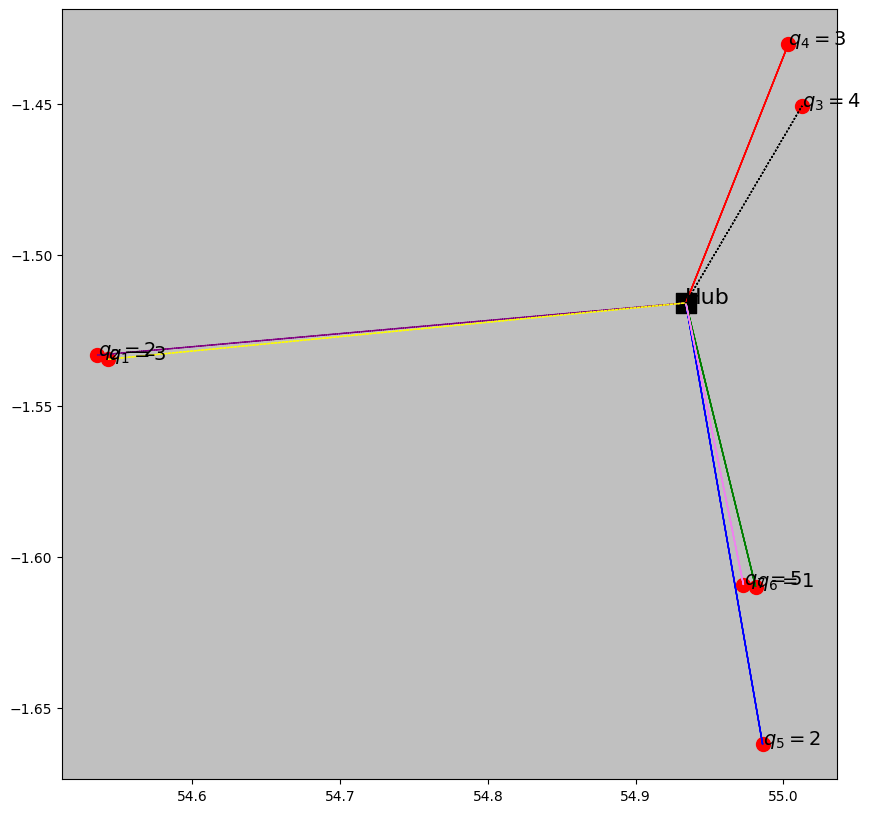

In [85]:
plt.figure(figsize=(10,10))
ax=plt.axes()
ax.set_facecolor('silver')


for i in range(customers):
    if i == 0:
        plt.scatter(df.lat[i], df.long[i], c='black', marker='s', s=200)
        plt.text(df.lat[i]-0.001, df.long[i], "Hub", fontsize=16)
    else:
        plt.scatter(df.lat[i], df.long[i], c='red', s=100)
        plt.text((df.lat[i]+0.0001), df.long[i], ('$q_%d=%d$'%((i,df.demand[i]))), fontsize=14)


color_list = ["red","blue","green","violet",'plum']

car_deliveries_test_4= []

for k in range(car_vehicles_test_4):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xt[i][j][k]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001, head_width=0.0002, color=color_list[k], length_includes_head=True)
                car_deliveries_test_4.append([df.long[j], df.lat[j]] )

color_list_d = ["purple","yellow",'black','lime']

drone_deliveries_test_4 = []

for kd in range(drone_vehicle_test_4):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xd[i][j][kd]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001,length_includes_head=True, head_width=0.0002, color=color_list_d[kd],
                          linestyle='dotted')

                drone_deliveries_test_4.append( [(hub_lat,hub_long), (df.lat[j], df.long[j])] )

# Below are the cars trips with green color

In [86]:
car_deliveries_test_4

[[np.float64(-1.430334), np.float64(55.003274)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.661928), np.float64(54.985921)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.609814), np.float64(54.981166)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.609099), np.float64(54.972907)],
 [np.float64(-1.5159), np.float64(54.934)]]

In [87]:
map_car_test_4 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)


for i in range(len(car_deliveries_test_4)):
    coordinates  = [ initial_loc , car_deliveries_test_4[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-car',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(map_car_test_4)

map_car_test_4

# Below is the drone trip with purple color

In [88]:
drone_deliveries_test_4

[[(54.934, -1.5159), (np.float64(54.535897), np.float64(-1.533183))],
 [(54.934, -1.5159), (np.float64(54.934), np.float64(-1.5159))],
 [(54.934, -1.5159), (np.float64(54.542723), np.float64(-1.534555))],
 [(54.934, -1.5159), (np.float64(54.934), np.float64(-1.5159))],
 [(54.934, -1.5159), (np.float64(55.012553), np.float64(-1.450754))],
 [(54.934, -1.5159), (np.float64(54.934), np.float64(-1.5159))]]

In [89]:
map_drones_test_4 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=16)

for i in range(len(drone_deliveries_test_4)):
    folium.PolyLine(drone_deliveries_test_4[i], color = 'purple').add_to(map_drones_test_4)

map_drones_test_4

* The combined map of all the journeys made by each vehicle, each time

In [90]:
# Create the final map route for the cars

# Remove the titles parameter if you wish to get a realistic map

combination_map_car_drones_test_4 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(car_deliveries_test_4)):
    coordinates  = [ initial_loc , car_deliveries_test_4[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-car',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(combination_map_car_drones_test_4)



# Create the final map route for the drones
for i in range(len(drone_deliveries_test_4)):
    folium.PolyLine(drone_deliveries_test_4, color = 'purple').add_to(combination_map_car_drones_test_4)

combination_map_car_drones_test_4

# Autonomous Vehicles VS Drones

In [91]:
autonomous_vehicles_test_1 = 4
autonomous_vehicles_capacity_test_1 = 30
fixed_cost_autonomous_vehicles_test_1 = 4

drones_vehicles_test_1 = 3
drones_capacity_test_1 = 4

for autonomous_vehicles_test_1 in range(1,autonomous_vehicles_test_1+1):

    prob = LpProblem("VRPD", LpMinimize)

    # Define decision variables for autonomous_vehicles_test_1 and drone
    xt = [[[LpVariable("xt%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None
            for k in range(autonomous_vehicles_test_1)]for j in range(customers)] for i in range(customers)]

    xd = [[[LpVariable("xd%s_%s,%s"%(i,j,kd), cat="Binary") if i != j else None
            for kd in range(drones_vehicles_test_1)]for j in range(customers)] for i in range(customers)]

    # Objective function - Minimize total travel cost
    prob += lpSum((distance_cycling_electric[i][j] * xt[i][j][k]) if i != j else 0
                        for k in range(autonomous_vehicles_test_1)
                        for j in range(customers)
                        for i in range (customers)) + lpSum((fixed_cost_autonomous_vehicles_test_1 * xt[0][j][k])
                                                            for k in range(autonomous_vehicles_test_1)
                                                            for j in range(1,customers)) + lpSum((distance_drone[i][j] * xd[i][j][kd] if i!=j else 0
                                                                                                  for kd in range(drones_vehicles_test_1)
                                                                                                  for j in range(customers)
                                                                                                  for i in range(customers)))


    # Constraint 1 - Customer is only served once by only one vehicle
    for j in range(1, customers):
        prob += lpSum(xt[i][j][k] if i != j else 0
                      for i in range(customers)
                      for k in range(autonomous_vehicles_test_1)) + lpSum(xd[i][j][kd] if i != j else 0
                                                      for i in range(customers)
                                                      for kd in range(drones_vehicles_test_1)) == 1


    # Constraint 2 - Vehicle must depart from and return to depot
    for k in range(autonomous_vehicles_test_1):
        prob += lpSum(xt[0][j][k] for j in range(1,customers)) == 1
        prob += lpSum(xt[i][0][k] for i in range(1,customers)) == 1


    for kd in range(drones_vehicles_test_1):
        prob += lpSum(xd[0][j][kd] for j in range(1,customers)) == 1
        prob += lpSum(xd[i][0][kd] for i in range(1,customers)) == 1


    # Constraint 3 - Only one vehicle enters and leaves each customer location
    for k in range(autonomous_vehicles_test_1):
        for kd in range(drones_vehicles_test_1):
            for j in range(customers):
                prob += (lpSum(xt[i][j][k] if i != j else 0
                               for i in range(customers)) + lpSum(xd[i][j][kd] if i!=j else 0
                                                                  for i in range(customers))) - (lpSum(xt[j][i][k]
                                                                                                       for i in range(customers)) + lpSum(xd[j][i][kd]
                                                                                                                                          for i in range(customers))) == 0


    # Constraint 4 - Demand must not exceed vehicle capacity
    for k in range(autonomous_vehicles_test_1):
        prob += lpSum(df.demand[j] * xt[i][j][k] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= autonomous_vehicles_capacity_test_1

    for kd in range(drones_vehicles_test_1):
        prob += lpSum(df.demand[j] * xd[i][j][kd] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= drones_capacity_test_1


    # Constraint 4 - Subtour elimination
    subtours = []
    for i in range(2,customers):
        subtours += itertools.combinations(range(1,customers), i)


    for s in subtours:
        prob += lpSum(xt[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for k in range(autonomous_vehicles_test_1)) <= len(s) - 1


    for s in subtours:
        prob += lpSum(xd[i][j][kd] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for kd in range(drones_vehicles_test_1)) <= len(s) - 1


    if prob.solve(CPLEX_PY()) == 1:
        prob.writeLP("VRPDModel.lp")

    for v in prob.variables():

        print(v.name, "=", v.varValue)
        print('Status:', LpStatus[prob.status],"\n")
        print(f"In order to solve the VRPD Problem, we will use", (autonomous_vehicles_test_1) ,"Autonomous Vehicles")
        print(f"In order to solve the VRPD Problem, we will use" , (drones_vehicles_test_1) ,"Drones")
        print('Total distance we will have to travel is: ', pulp.value(prob.objective),"\n")

        break

Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 92 rows and 39 columns.
MIP Presolve modified 162 coefficients.
Reduced MIP has 188 rows, 185 columns, and 2664 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.35 ticks)
Found incumbent of value 271593.500000 after 0.02 sec. (7.49 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.64 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 11 rows and 30 columns.
MIP Presolve modified 25 coefficients.
Reduced MIP has 177 rows, 155 columns, and 2322 nonzeros.
Reduced MIP has 155 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.71 ticks)
Probing time = 0.00 sec. (1.83 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1 rows and 0 columns.
Reduced MI

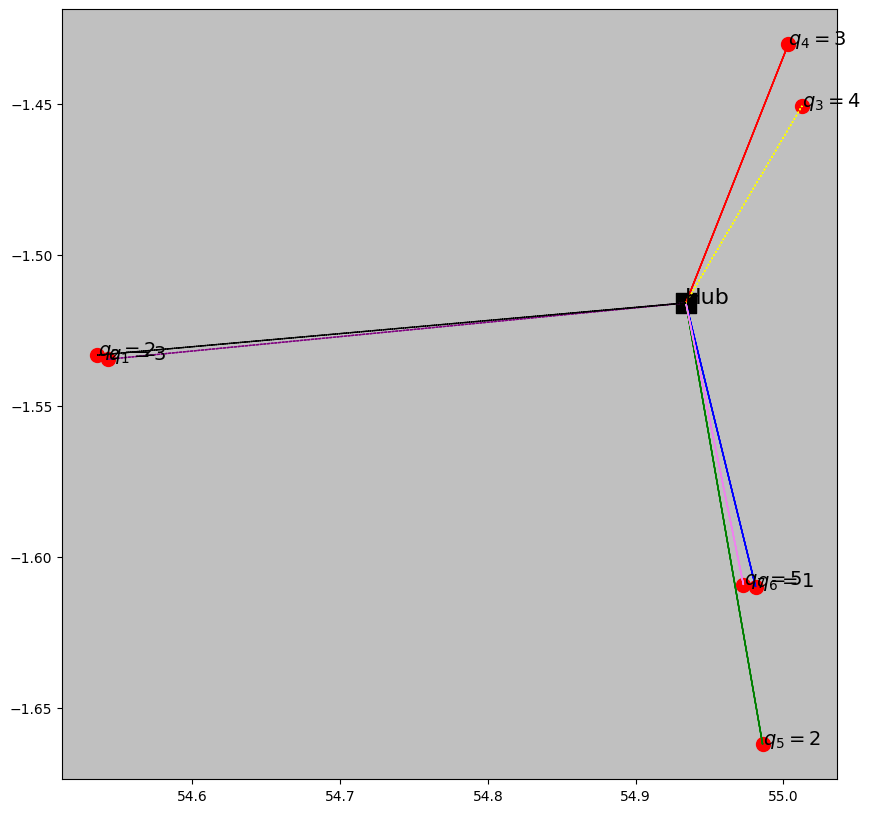

In [92]:
plt.figure(figsize=(10,10))
ax=plt.axes()
ax.set_facecolor('silver')


for i in range(customers):
    if i == 0:
        plt.scatter(df.lat[i], df.long[i], c='black', marker='s', s=200)
        plt.text(df.lat[i]-0.001, df.long[i], "Hub", fontsize=16)
    else:
        plt.scatter(df.lat[i], df.long[i], c='red', s=100)
        plt.text((df.lat[i]+0.0001), df.long[i], ('$q_%d=%d$'%((i,df.demand[i]))), fontsize=14)


color_list = ["red","blue","green","violet",'plum']

autonomous_vehicles_deliveries_test_1 = []

for k in range(autonomous_vehicles_test_1):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xt[i][j][k]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001, head_width=0.0002, color=color_list[k], length_includes_head=True)
                autonomous_vehicles_deliveries_test_1.append([df.long[j], df.lat[j]] )

color_list_d = ["purple","yellow",'black','lime']

drones_deliveries_test_1 = []

for kd in range(drones_vehicles_test_1):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xd[i][j][kd]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001,length_includes_head=True, head_width=0.0002, color=color_list_d[kd],
                          linestyle='dotted')

                drones_deliveries_test_1.append( [(hub_lat,hub_long), (df.lat[j], df.long[j])] )

# Below is the autonomous vehicle map

In [93]:
autonomous_vehicles_deliveries_test_1

[[np.float64(-1.430334), np.float64(55.003274)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.609814), np.float64(54.981166)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.661928), np.float64(54.985921)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.609099), np.float64(54.972907)],
 [np.float64(-1.5159), np.float64(54.934)]]

In [94]:
autonomous_vehicles_map_test_1 = folium.Map(location=[hub_lat,hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(autonomous_vehicles_deliveries_test_1)):
    coordinates  = [ initial_loc , autonomous_vehicles_deliveries_test_1[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='cycling-electric',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(autonomous_vehicles_map_test_1)

autonomous_vehicles_map_test_1

/usr/local/lib/python3.11/dist-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 9th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,


# Below is the drone map

In [95]:
drones_deliveries_test_1

[[(54.934, -1.5159), (np.float64(54.542723), np.float64(-1.534555))],
 [(54.934, -1.5159), (np.float64(54.934), np.float64(-1.5159))],
 [(54.934, -1.5159), (np.float64(55.012553), np.float64(-1.450754))],
 [(54.934, -1.5159), (np.float64(54.934), np.float64(-1.5159))],
 [(54.934, -1.5159), (np.float64(54.535897), np.float64(-1.533183))],
 [(54.934, -1.5159), (np.float64(54.934), np.float64(-1.5159))]]

In [96]:
map_drones_test_1 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=16)

for i in range(len(drones_deliveries_test_1)):
    folium.PolyLine(drones_deliveries_test_1[i], color = 'purple').add_to(map_drones_test_1)

map_drones_test_1

* The combined map of all the journeys made by each vehicle, each time

In [97]:
combination_map_autonomous_vehicles_drones_test_1 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(autonomous_vehicles_deliveries_test_1)):
    coordinates  = [ initial_loc , autonomous_vehicles_deliveries_test_1[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='cycling-electric',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(combination_map_autonomous_vehicles_drones_test_1)


for i in range(len(drones_deliveries_test_1)):
    folium.PolyLine(drones_deliveries_test_1, color = 'purple').add_to(combination_map_autonomous_vehicles_drones_test_1)

combination_map_autonomous_vehicles_drones_test_1

HGV VS CAR

In [98]:
hgv_vehicles_test_2 = 4
hgv_vehicles_capacity_test_2 = 30
fixed_cost_hgv_vehicles_test_2 = 4

car_vehicles_test_2 = 3
car_vehicles_capacity_test_2 = 4

for hgv_vehicles_test_2 in range(1,hgv_vehicles_test_2+1):

    prob = LpProblem("VRPD", LpMinimize)

    # Define decision variables for hgv_vehicles_test_2 and car_vehicles_test_2
    xt = [[[LpVariable("xt%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None
            for k in range(hgv_vehicles_test_2)]for j in range(customers)] for i in range(customers)]

    xd = [[[LpVariable("xd%s_%s,%s"%(i,j,kd), cat="Binary") if i != j else None
            for kd in range(car_vehicles_test_2)]for j in range(customers)] for i in range(customers)]

    # Objective function - Minimize total travel cost
    prob += lpSum((distance_driving_hgv[i][j] * xt[i][j][k]) if i != j else 0
                        for k in range(hgv_vehicles_test_2)
                        for j in range(customers)
                        for i in range (customers)) + lpSum((fixed_cost_hgv_vehicles_test_2 * xt[0][j][k])
                                                            for k in range(hgv_vehicles_test_2)
                                                            for j in range(1,customers)) + lpSum((distance_driving_car[i][j] * xd[i][j][kd] if i!=j else 0
                                                                                                  for kd in range(car_vehicles_test_2)
                                                                                                  for j in range(customers)
                                                                                                  for i in range(customers)))


    # Constraint 1 - Customer is only served once by only one vehicle
    for j in range(1, customers):
        prob += lpSum(xt[i][j][k] if i != j else 0
                      for i in range(customers)
                      for k in range(hgv_vehicles_test_2)) + lpSum(xd[i][j][kd] if i != j else 0
                                                      for i in range(customers)
                                                      for kd in range(car_vehicles_test_2)) == 1


    # Constraint 2 - Vehicle must depart from and return to depot
    for k in range(hgv_vehicles_test_2):
        prob += lpSum(xt[0][j][k] for j in range(1,customers)) == 1
        prob += lpSum(xt[i][0][k] for i in range(1,customers)) == 1


    for kd in range(car_vehicles_test_2):
        prob += lpSum(xd[0][j][kd] for j in range(1,customers)) == 1
        prob += lpSum(xd[i][0][kd] for i in range(1,customers)) == 1


    # Constraint 3 - Only one vehicle enters and leaves each customer location
    for k in range(hgv_vehicles_test_2):
        for kd in range(car_vehicles_test_2):
            for j in range(customers):
                prob += (lpSum(xt[i][j][k] if i != j else 0
                               for i in range(customers)) + lpSum(xd[i][j][kd] if i!=j else 0
                                                                  for i in range(customers))) - (lpSum(xt[j][i][k]
                                                                                                       for i in range(customers)) + lpSum(xd[j][i][kd]
                                                                                                                                          for i in range(customers))) == 0


    # Constraint 4 - Demand must not exceed vehicle capacity
    for k in range(hgv_vehicles_test_2):
        prob += lpSum(df.demand[j] * xt[i][j][k] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= hgv_vehicles_capacity_test_2

    for kd in range(car_vehicles_test_2):
        prob += lpSum(df.demand[j] * xd[i][j][kd] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= car_vehicles_capacity_test_2


    # Constraint 4 - Subtour elimination
    subtours = []
    for i in range(2,customers):
        subtours += itertools.combinations(range(1,customers), i)


    for s in subtours:
        prob += lpSum(xt[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for k in range(hgv_vehicles_test_2)) <= len(s) - 1


    for s in subtours:
        prob += lpSum(xd[i][j][kd] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for kd in range(car_vehicles_test_2)) <= len(s) - 1


    if prob.solve(CPLEX_PY()) == 1:
        prob.writeLP("VRPDModel.lp")

    for v in prob.variables():

        print(v.name, "=", v.varValue)
        print('Status:', LpStatus[prob.status],"\n")
        print(f"In order to solve the VRPD Problem, we will use", (hgv_vehicles_test_2) ,"HGVs")
        print(f"In order to solve the VRPD Problem, we will use" , (car_vehicles_test_2) ,"Cars")
        print('Total distance we will have to travel is: ', pulp.value(prob.objective),"\n")

        break

Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 92 rows and 39 columns.
MIP Presolve modified 162 coefficients.
Reduced MIP has 188 rows, 185 columns, and 2664 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.35 ticks)
Found incumbent of value 321002.700000 after 0.02 sec. (7.49 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.64 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 11 rows and 30 columns.
MIP Presolve modified 25 coefficients.
Reduced MIP has 177 rows, 155 columns, and 2322 nonzeros.
Reduced MIP has 155 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.71 ticks)
Probing time = 0.00 sec. (1.83 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1 rows and 0 columns.
Reduced MI

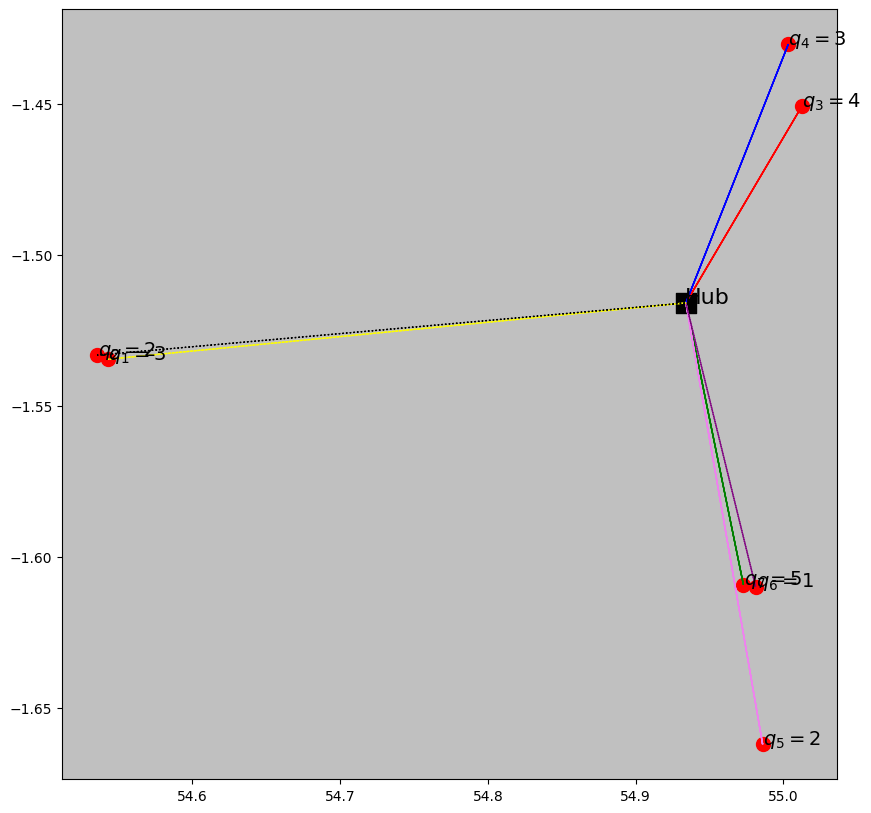

In [99]:
plt.figure(figsize=(10,10))
ax=plt.axes()
ax.set_facecolor('silver')


for i in range(customers):
    if i == 0:
        plt.scatter(df.lat[i], df.long[i], c='black', marker='s', s=200)
        plt.text(df.lat[i]-0.001, df.long[i], "Hub", fontsize=16)
    else:
        plt.scatter(df.lat[i], df.long[i], c='red', s=100)
        plt.text((df.lat[i]+0.0001), df.long[i], ('$q_%d=%d$'%((i,df.demand[i]))), fontsize=14)


color_list = ["red","blue","green","violet",'plum']

hgvs_deliveries_test_2 = []

for k in range(hgv_vehicles_test_2):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xt[i][j][k]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001, head_width=0.0002, color=color_list[k], length_includes_head=True)
                hgvs_deliveries_test_2.append([df.long[j], df.lat[j]] )

color_list_d = ["purple","yellow",'black','lime']

car_deliveries_test_2 = []


for kd in range(car_vehicles_test_2):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xd[i][j][kd]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001,length_includes_head=True, head_width=0.0002, color=color_list_d[kd],
                          linestyle='dotted')

                car_deliveries_test_2.append([df.long[j], df.lat[j]] )

In [100]:
hgvs_deliveries_test_2

[[np.float64(-1.450754), np.float64(55.012553)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.430334), np.float64(55.003274)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.609099), np.float64(54.972907)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.661928), np.float64(54.985921)],
 [np.float64(-1.5159), np.float64(54.934)]]

In [101]:
hgvs_map_test_2 = folium.Map(location=[hub_lat,hub_long], tiles='cartodbpositron',zoom_start=14)


for i in range(len(hgvs_deliveries_test_2)):
    coordinates  = [ initial_loc , hgvs_deliveries_test_2[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-hgv',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(hgvs_map_test_2)

hgvs_map_test_2

# Belows is the car map

In [102]:
car_deliveries_test_2

[[np.float64(-1.609814), np.float64(54.981166)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.534555), np.float64(54.542723)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.533183), np.float64(54.535897)]]

In [103]:
map_cars_test_2 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(car_deliveries_test_2)):
    coordinates  = [ initial_loc , car_deliveries_test_2[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-car',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'purple').add_to(map_cars_test_2)

map_cars_test_2

In [104]:
combination_map_hgvs_cars_test_2 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(hgvs_deliveries_test_2)):
    coordinates  = [ initial_loc , hgvs_deliveries_test_2[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-hgv',
        format='geojson',
        validate=False
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(combination_map_hgvs_cars_test_2)



# Create the final map route for the car
for i in range(len(car_deliveries_test_2)):
    coordinates  = [ initial_loc , car_deliveries_test_2[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-car',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'purple').add_to(combination_map_hgvs_cars_test_2)


combination_map_hgvs_cars_test_2

### HGVs VS Drones

In [105]:
hgv_vehicles_test_3 = 4
hgv_vehicles_capacity_test_3 = 14
fixed_cost_hgv_vehicles_test_3 = 4

drone_vehicle_test_3 = 3
drone_capacity_test_3 = 13


for hgv_vehicles_test_3 in range(1,hgv_vehicles_test_3+1):

    prob = LpProblem("VRPD", LpMinimize)

    # Define decision variables for hgv_vehicles_test_3 and drone
    xt = [[[LpVariable("xt%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None
            for k in range(hgv_vehicles_test_3)]for j in range(customers)] for i in range(customers)]

    xd = [[[LpVariable("xd%s_%s,%s"%(i,j,kd), cat="Binary") if i != j else None
            for kd in range(drone_vehicle_test_3)]for j in range(customers)] for i in range(customers)]

    # Objective function - Minimize total travel cost
    prob += lpSum((distance_driving_hgv[i][j] * xt[i][j][k]) if i != j else 0
                        for k in range(hgv_vehicles_test_3)
                        for j in range(customers)
                        for i in range (customers)) + lpSum((fixed_cost_hgv_vehicles_test_3 * xt[0][j][k])
                                                            for k in range(hgv_vehicles_test_3)
                                                            for j in range(1,customers)) + lpSum((distance_drone[i][j] * xd[i][j][kd] if i!=j else 0
                                                                                                  for kd in range(drone_vehicle_test_3)
                                                                                                  for j in range(customers)
                                                                                                  for i in range(customers)))


    # Constraint 1 - Customer is only served once by only one vehicle
    for j in range(1, customers):
        prob += lpSum(xt[i][j][k] if i != j else 0
                      for i in range(customers)
                      for k in range(hgv_vehicles_test_3)) + lpSum(xd[i][j][kd] if i != j else 0
                                                      for i in range(customers)
                                                      for kd in range(drone_vehicle_test_3)) == 1


    # Constraint 2 - Vehicle must depart from and return to depot
    for k in range(hgv_vehicles_test_3):
        prob += lpSum(xt[0][j][k] for j in range(1,customers)) == 1
        prob += lpSum(xt[i][0][k] for i in range(1,customers)) == 1


    for kd in range(drone_vehicle_test_3):
        prob += lpSum(xd[0][j][kd] for j in range(1,customers)) == 1
        prob += lpSum(xd[i][0][kd] for i in range(1,customers)) == 1


    # Constraint 3 - Only one vehicle enters and leaves each customer location
    for k in range(hgv_vehicles_test_3):
        for kd in range(drone_vehicle_test_3):
            for j in range(customers):
                prob += (lpSum(xt[i][j][k] if i != j else 0
                               for i in range(customers)) + lpSum(xd[i][j][kd] if i!=j else 0
                                                                  for i in range(customers))) - (lpSum(xt[j][i][k]
                                                                                                       for i in range(customers)) + lpSum(xd[j][i][kd]
                                                                                                                                          for i in range(customers))) == 0


    # Constraint 3 - Demand must not exceed vehicle capacity
    for k in range(hgv_vehicles_test_3):
        prob += lpSum(df.demand[j] * xt[i][j][k] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= hgv_vehicles_capacity_test_3

    for kd in range(drone_vehicle_test_3):
        prob += lpSum(df.demand[j] * xd[i][j][kd] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= drone_capacity_test_3


    # Constraint 4 - Subtour elimination
    subtours = []
    for i in range(2,customers):
        subtours += itertools.combinations(range(1,customers), i)


    for s in subtours:
        prob += lpSum(xt[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for k in range(hgv_vehicles_test_3)) <= len(s) - 1


    for s in subtours:
        prob += lpSum(xd[i][j][kd] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for kd in range(drone_vehicle_test_3)) <= len(s) - 1


    if prob.solve(CPLEX_PY()) == 1:
        prob.writeLP("VRPDModel.lp")

    for v in prob.variables():

        print(v.name, "=", v.varValue)
        print('Status:', LpStatus[prob.status],"\n")
        print(f"In order to solve the VRPD Problem, we will use", (hgv_vehicles_test_3) ,"HGVs")
        print(f"In order to solve the VRPD Problem, we will use" , (drone_vehicle_test_3) ,"Drones")
        print('Total distance we will have to travel is: ', pulp.value(prob.objective),"\n")

        break

Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve modified 112 coefficients.
Reduced MIP has 280 rows, 224 columns, and 6404 nonzeros.
Reduced MIP has 224 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.85 ticks)
Found incumbent of value 249860.300000 after 0.02 sec. (12.55 ticks)
Probing time = 0.00 sec. (3.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 280 rows, 224 columns, and 6404 nonzeros.
Reduced MIP has 224 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.34 ticks)
Probing time = 0.00 sec. (3.10 ticks)
Clique table members: 1562.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 2 threads.
Root relaxation solution time = 0.01 sec. (0.79 ticks)

        Nodes                                         Cuts/
   Node  Left     Object

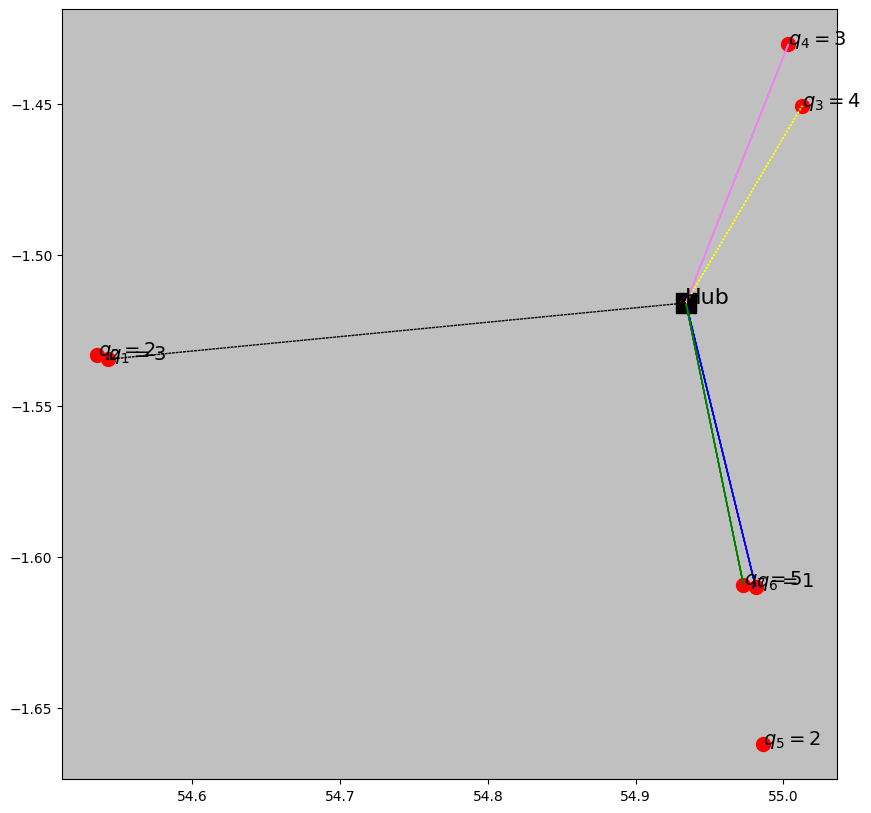

In [106]:
plt.figure(figsize=(10,10))
ax=plt.axes()
ax.set_facecolor('silver')


for i in range(customers):
    if i == 0:
        plt.scatter(df.lat[i], df.long[i], c='black', marker='s', s=200)
        plt.text(df.lat[i]-0.001, df.long[i], "Hub", fontsize=16)
    else:
        plt.scatter(df.lat[i], df.long[i], c='red', s=100)
        plt.text((df.lat[i]+0.0001), df.long[i], ('$q_%d=%d$'%((i,df.demand[i]))), fontsize=14)


color_list = ["red","blue","green","violet",'plum']

hgvs_deliveries_test_3 = []

for k in range(hgv_vehicles_test_3):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xt[i][j][k]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001, head_width=0.0002, color=color_list[k], length_includes_head=True)
                hgvs_deliveries_test_3.append([df.long[j], df.lat[j]] )

color_list_d = ["purple","yellow",'black','lime']

drones_deliveries_test_3 = []

for kd in range(drone_vehicle_test_3):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xd[i][j][kd]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001,length_includes_head=True, head_width=0.0002, color=color_list_d[kd],
                          linestyle='dotted')

                drones_deliveries_test_3.append( [(hub_lat,hub_long), (df.lat[j], df.long[j])] )

In [107]:
hgvs_map_test_3 = folium.Map(location=[hub_lat,hub_long], tiles='cartodbpositron',zoom_start=14)


for i in range(len(hgvs_deliveries_test_3)):
    coordinates  = [ initial_loc , hgvs_deliveries_test_3[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-hgv',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(hgvs_map_test_3)

hgvs_map_test_3

In [108]:
map_drone_test_3 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(drones_deliveries_test_3)):
    folium.PolyLine(drones_deliveries_test_3[i], color = 'purple').add_to(map_drone_test_3)

map_drone_test_3

In [109]:
combination_map_hgvs_drones = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(hgvs_deliveries_test_3)):
    coordinates  = [ initial_loc , hgvs_deliveries_test_3[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='cycling-electric',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(combination_map_hgvs_drones)



# Create the final map route for the drones
for i in range(len(drones_deliveries_test_3)):
    folium.PolyLine(drones_deliveries_test_3, color = 'purple').add_to(combination_map_hgvs_drones)

combination_map_hgvs_drones

### AVs VS Cars

In [110]:
autonomous_vehicles_test_4 = 4
autonomous_vehicles_capacity_test_4 = 30
fixed_cost_autonomous_vehicles_test_4 = 4

cars_vehicles_test_4 = 3
cars_capacity_test_4 = 4


for autonomous_vehicles_test_4 in range(1, autonomous_vehicles_test_4 + 1):

    prob = LpProblem("VRPD", LpMinimize)

    # Define decision variables for autonomous_vehicles_test_4 and drone
    xt = [[[LpVariable("xt%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None
            for k in range(autonomous_vehicles_test_4)]for j in range(customers)] for i in range(customers)]

    xd = [[[LpVariable("xd%s_%s,%s"%(i,j,kd), cat="Binary") if i != j else None
            for kd in range(cars_vehicles_test_4)]for j in range(customers)] for i in range(customers)]

    # Objective function - Minimize total travel cost
    prob += lpSum((distance_cycling_electric[i][j] * xt[i][j][k]) if i != j else 0
                        for k in range(autonomous_vehicles_test_4)
                        for j in range(customers)
                        for i in range (customers)) + lpSum((fixed_cost_autonomous_vehicles_test_4 * xt[0][j][k])
                                                            for k in range(autonomous_vehicles_test_4)
                                                            for j in range(1,customers)) + lpSum((distance_driving_car[i][j] * xd[i][j][kd] if i!=j else 0
                                                                                                  for kd in range(cars_vehicles_test_4)
                                                                                                  for j in range(customers)
                                                                                                  for i in range(customers)))


    # Constraint 1 - Customer is only served once by only one vehicle
    for j in range(1, customers):
        prob += lpSum(xt[i][j][k] if i != j else 0
                      for i in range(customers)
                      for k in range(autonomous_vehicles_test_4)) + lpSum(xd[i][j][kd] if i != j else 0
                                                      for i in range(customers)
                                                      for kd in range(cars_vehicles_test_4)) == 1


    # Constraint 2 - Vehicle must depart from and return to depot
    for k in range(autonomous_vehicles_test_4):
        prob += lpSum(xt[0][j][k] for j in range(1,customers)) == 1
        prob += lpSum(xt[i][0][k] for i in range(1,customers)) == 1


    for kd in range(cars_vehicles_test_4):
        prob += lpSum(xd[0][j][kd] for j in range(1,customers)) == 1
        prob += lpSum(xd[i][0][kd] for i in range(1,customers)) == 1


    # Constraint 3 - Only one vehicle enters and leaves each customer location
    for k in range(autonomous_vehicles_test_4):
        for kd in range(cars_vehicles_test_4):
            for j in range(customers):
                prob += (lpSum(xt[i][j][k] if i != j else 0
                               for i in range(customers)) + lpSum(xd[i][j][kd] if i!=j else 0
                                                                  for i in range(customers))) - (lpSum(xt[j][i][k]
                                                                                                       for i in range(customers)) + lpSum(xd[j][i][kd]
                                                                                                                                          for i in range(customers))) == 0


    # Constraint 4 - Demand must not exceed vehicle capacity
    for k in range(autonomous_vehicles_test_4):
        prob += lpSum(df.demand[j] * xt[i][j][k] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= autonomous_vehicles_capacity_test_4

    for kd in range(cars_vehicles_test_4):
        prob += lpSum(df.demand[j] * xd[i][j][kd] if i != j else 0
                      for i in range(customers) for j in range (1,customers)) <= cars_capacity_test_4


    # Constraint 4 - Subtour elimination
    subtours = []
    for i in range(2,customers):
        subtours += itertools.combinations(range(1,customers), i)


    for s in subtours:
        prob += lpSum(xt[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for k in range(autonomous_vehicles_test_4)) <= len(s) - 1


    for s in subtours:
        prob += lpSum(xd[i][j][kd] if i !=j else 0 for i, j in itertools.permutations(s,2)
                      for kd in range(cars_vehicles_test_4)) <= len(s) - 1


    if prob.solve(CPLEX_PY()) == 1:
        prob.writeLP("VRPDModel.lp")

    for v in prob.variables():

        print(v.name, "=", v.varValue)
        print('Status:', LpStatus[prob.status],"\n")
        print(f"In order to solve the VRPD Problem, we will use", (autonomous_vehicles_test_4) ,"Autonomous Vehicles")
        print(f"In order to solve the VRPD Problem, we will use" , (cars_vehicles_test_4) ,"Cars")
        print('Total distance we will have to travel is: ', pulp.value(prob.objective),"\n")

        break

Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 92 rows and 39 columns.
MIP Presolve modified 162 coefficients.
Reduced MIP has 188 rows, 185 columns, and 2664 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.35 ticks)
Found incumbent of value 324847.400000 after 0.02 sec. (7.49 ticks)
Probing fixed 30 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.64 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 11 rows and 30 columns.
MIP Presolve modified 25 coefficients.
Reduced MIP has 177 rows, 155 columns, and 2322 nonzeros.
Reduced MIP has 155 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.71 ticks)
Probing time = 0.00 sec. (1.83 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1 rows and 0 columns.
Reduced MI

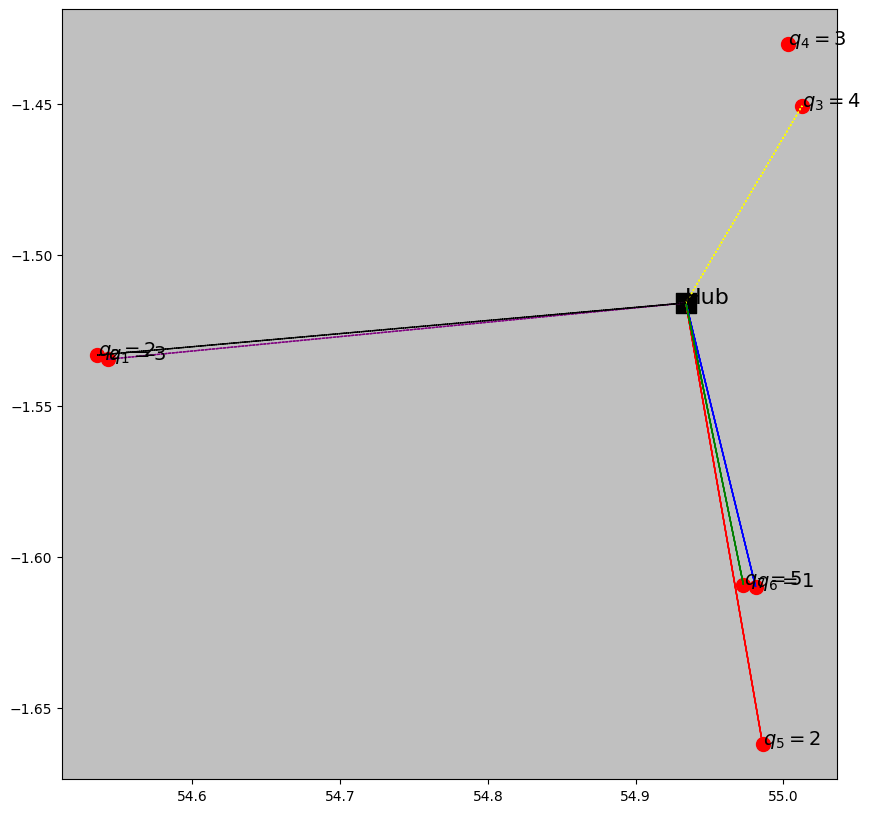

In [111]:
plt.figure(figsize=(10,10))
ax=plt.axes()
ax.set_facecolor('silver')


for i in range(customers):
    if i == 0:
        plt.scatter(df.lat[i], df.long[i], c='black', marker='s', s=200)
        plt.text(df.lat[i]-0.001, df.long[i], "Hub", fontsize=16)
    else:
        plt.scatter(df.lat[i], df.long[i], c='red', s=100)
        plt.text((df.lat[i]+0.0001), df.long[i], ('$q_%d=%d$'%((i,df.demand[i]))), fontsize=14)


color_list = ["red","blue","green","violet",'plum']

cars_deliveries_test_4 = []

for k in range(cars_vehicles_test_4):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xt[i][j][k]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001, head_width=0.0002, color=color_list[k], length_includes_head=True)
                cars_deliveries_test_4.append([df.long[j], df.lat[j]] )

color_list_d = ["purple","yellow",'black','lime']

autonomous_vehicles_deliveries_test_4 = []

for kd in range(drone_vehicle_test_4):
    for i in range(customers):
        for j in range(customers):
            if i != j and pulp.value(xd[i][j][kd]) == 1:
                plt.arrow(df.lat[i], df.long[i], (df.lat[j] - df.lat[i]), (df.long[j] - df.long[i]),
                          width=0.00001,length_includes_head=True, head_width=0.0002, color=color_list_d[kd],
                          linestyle='dotted')

                autonomous_vehicles_deliveries_test_4.append([df.long[j], df.lat[j]])

In [112]:
autonomous_vehicles_deliveries_test_4

[[np.float64(-1.534555), np.float64(54.542723)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.450754), np.float64(55.012553)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.533183), np.float64(54.535897)],
 [np.float64(-1.5159), np.float64(54.934)]]

In [113]:
map_cars_test_4 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(cars_deliveries_test_4)):
    coordinates  = [ initial_loc , cars_deliveries_test_4[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-car',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(map_cars_test_4)

map_cars_test_4

In [114]:
autonomous_vehicles_deliveries_test_4

[[np.float64(-1.534555), np.float64(54.542723)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.450754), np.float64(55.012553)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.533183), np.float64(54.535897)],
 [np.float64(-1.5159), np.float64(54.934)]]

In [115]:
autonomous_vehicles_cars_test_4 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(autonomous_vehicles_deliveries_test_4)):
    coordinates  = [ initial_loc , autonomous_vehicles_deliveries_test_4[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='cycling-electric',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'purple').add_to(autonomous_vehicles_cars_test_4)

autonomous_vehicles_cars_test_4

In [116]:
combination_map_autonomous_vehicles_cars_test_4 = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron',zoom_start=14)

for i in range(len(cars_deliveries_test_4)):
    coordinates  = [ initial_loc , cars_deliveries_test_4[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='driving-car',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'green').add_to(combination_map_autonomous_vehicles_cars_test_4)


# Create the final map route for the car
for i in range(len(autonomous_vehicles_deliveries_test_4)):
    coordinates  = [ initial_loc , autonomous_vehicles_deliveries_test_4[i]]

    route = client.directions(
        coordinates=coordinates,
        profile='cycling-electric',
        format='geojson',
        validate=False,
        )

    folium.PolyLine(locations=[list(reversed(coord))
                                    for coord in
                                        route['features'][0]['geometry']['coordinates']], color = 'purple').add_to(combination_map_autonomous_vehicles_cars_test_4)



combination_map_autonomous_vehicles_cars_test_4

### Plot the total distances and duration for each route and for each vehicle

* If you wish to get a new map for a different vehicle just replace the profile variable

In [117]:
# Set the OpenRouteService API key
api_key = '5b3ce3597851110001cf62480269346609c64a5184f27e5a9f0c84e5'  # Replace with your actual API key
client = openrouteservice.Client(key=api_key)

# Profile to use for directions (driving-car, driving-hgv, etc.)
selected_profile = 'driving-car'  # Change this based on the profile you want to use

# Create a folium map centered at the hub's coordinates
dur_dis_map = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron', zoom_start=15)

# Create a list of coordinates from the dataframe
coords_list = [[[hub_long, hub_lat], coord] for coord in df['long_lat']]

# Iterate through the coordinates
for i, coords in enumerate(coords_list):
    # Check if not the initial location
    if coords != [initial_loc, initial_loc]:
        # Request directions using the selected profile
        res = client.directions(coordinates=coords, profile=selected_profile)

        # Extract distance and duration from the response
        segment = res['routes'][0]['segments'][0]
        distance = segment['distance']
        duration = segment['duration']

        # Print and display information
        print(f"The {i+1} route has total distance: {distance} meters and total duration: {duration} seconds")

        # Request directions using the selected profile (again?)
        res = client.directions(coordinates=coords, profile=selected_profile)
        geometry = res['routes'][0]['geometry']
        decoded = convert.decode_polyline(geometry)

        # Create the distance and duration text
        distance_txt = "<h4> <b>Distance: &nbsp;" + "<strong>" + str(round(distance, 1)) + " Meters </strong>" + "</h4></b>"
        duration_txt = "<h4> <b>Duration: &nbsp;" + "<strong>" + str(round(duration / 60, 1)) + " Minutes </strong>" + "</h4></b>"

        # Add the GeoJSON object and Popup to the map
        folium.GeoJson(decoded).add_child(folium.Popup(distance_txt + duration_txt, max_width=500)).add_to(dur_dis_map)
    else:
        print('I am back to the hub now')

# Iterate through the coordinates
# Create a list of coordinates from the dataframe
coords_list_destinations = [[row['lat'], row['long']] for _, row in df.iterrows()]

# Iterate through the coordinates
for coords in coords_list_destinations:
    # Add a marker for each destination
    folium.Marker(location=coords, icon=folium.Icon(color='green'), popup="Customers").add_to(dur_dis_map)

# Add a marker for the hub
folium.Marker(location=[hub_lat, hub_long], icon=folium.Icon(color='black'), popup="Hub").add_to(dur_dis_map)

# Show the map
dur_dis_map

I am back to the hub now
The 2 route has total distance: 49521.2 meters and total duration: 2175.9 seconds
The 3 route has total distance: 51409.7 meters and total duration: 2333.4 seconds
The 4 route has total distance: 16539.6 meters and total duration: 1191.9 seconds
The 5 route has total distance: 14992.9 meters and total duration: 1144.5 seconds
The 6 route has total distance: 15408.8 meters and total duration: 1241.7 seconds
The 7 route has total distance: 11539.3 meters and total duration: 1062.9 seconds
The 8 route has total distance: 10527.1 meters and total duration: 897.2 seconds
The 9 route has total distance: 5662.8 meters and total duration: 416.2 seconds


* I have produced a map below showing the clients each vehicle may serve
* Simply substitute another "vehicles deliveries x" from our database for "cars_deliveries_test_4" if you want to see the distances and durations for another vehicle

In [118]:
cars_deliveries_test_4

[[np.float64(-1.661928), np.float64(54.985921)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.609814), np.float64(54.981166)],
 [np.float64(-1.5159), np.float64(54.934)],
 [np.float64(-1.609099), np.float64(54.972907)],
 [np.float64(-1.5159), np.float64(54.934)]]

In [119]:
# Create a folium map centered at the hub's coordinates
dur_dis_map_new = folium.Map(location=[hub_lat, hub_long], tiles='cartodbpositron', zoom_start=16)

# Create a list of coordinates from the deliveries
coords_list_new = [[[hub_long, hub_lat], coord] for coord in cars_deliveries_test_4]

# Iterate through the coordinates and calculate distances
for j, coords in enumerate(coords_list_new):
    # Check if not the initial location
    if coords != [initial_loc, initial_loc]:
        # Request directions for driving car
        res = client.directions(coordinates=coords, profile='driving-car')

        # Extract distance and duration from the response
        segment = res['routes'][0]['segments'][0]
        distance = segment['distance']
        duration = segment['duration']

        # Print and display information
        print(f"The {j+1} route has total distance: {distance} meters and total duration: {duration} seconds")

        # Request directions for driving car (again?)
        res = client.directions(coordinates=coords, profile='driving-car')
        geometry = res['routes'][0]['geometry']
        decoded = convert.decode_polyline(geometry)

        # Create the distance and duration text
        distance_txt = "<h4> <b>Distance: &nbsp;" + "<strong>" + str(round(distance, 1)) + " Meters </strong>" + "</h4></b>"
        duration_txt = "<h4> <b>Duration: &nbsp;" + "<strong>" + str(round(duration / 60, 1)) + " Minutes </strong>" + "</h4></b>"

        # Add the GeoJSON object and Popup to the map
        folium.GeoJson(decoded).add_child(folium.Popup(distance_txt + duration_txt, max_width=400)).add_to(dur_dis_map_new)
    else:
        print('I am back to the hub now')

# Iterate through the coordinates
# Create a list of coordinates from the dataframe
coords_list_destinations = [[row['lat'], row['long']] for _, row in df.iterrows()]

# Iterate through the coordinates
for coords in coords_list_destinations:
    # Add a marker for each destination
    folium.Marker(location=coords, icon=folium.Icon(color='green'), popup="Customers").add_to(dur_dis_map_new)

# Add a marker for the hub
folium.Marker(location=[hub_lat, hub_long], icon=folium.Icon(color='black'), popup="Hub").add_to(dur_dis_map_new)

# Show the map
dur_dis_map_new

The 1 route has total distance: 15408.8 meters and total duration: 1241.7 seconds
I am back to the hub now
The 3 route has total distance: 11539.3 meters and total duration: 1062.9 seconds
I am back to the hub now
The 5 route has total distance: 10527.1 meters and total duration: 897.2 seconds
I am back to the hub now


### Below you can view a more generic solution of the problem

In [120]:
import cvxpy as cp

# Number of customers
n = 9

# Capacity of each vehicle type
drone_capacity = 4
car_capacity = 100
hgv_capacity = 20
autonomous_car_capacity = 14

# Total amount of parcels ordered by each customer
parcels = np.random.randint(1, 20, size=n)

# Distance from the hub to each customer
# This should be calculated using the openrouteservice API
distances = distance_driving_car

# Variables
x_drone = cp.Variable(n, boolean=True)
x_car = cp.Variable(n, boolean=True)
x_hgv = cp.Variable(n, boolean=True)
x_autonomous_car = cp.Variable(n, boolean=True)

# Constraints
constraints = [
    # Each customer must be delivered by exactly one vehicle
    x_drone + x_car + x_hgv + x_autonomous_car == np.ones(n),

    # Total capacity of each vehicle type must not be exceeded
    cp.matmul(parcels, x_drone) <= drone_capacity,
    cp.matmul(parcels, x_car) <= car_capacity,
    cp.matmul(parcels, x_hgv) <= hgv_capacity,
    cp.matmul(parcels, x_autonomous_car) <= autonomous_car_capacity,

    # Binary variables
    x_drone >= 0,
    x_drone <= 1,
    x_car >= 0,
    x_car <= 1,
    x_hgv >= 0,
    x_hgv <= 1,
    x_autonomous_car >= 0,
    x_autonomous_car <= 1,
]

# Objective
objective = cp.Minimize(cp.sum(cp.matmul(distances, x_drone + x_car + x_hgv + x_autonomous_car)))

# Problem
prob = cp.Problem(objective, constraints)

# Solve the problem
prob.solve(solver=cp.CPLEX)

# Print the solution
print("Optimal objective value:", prob.value)
print("x_drone =", x_drone.value)
print("x_car =", x_car.value)
print("x_hgv =", x_hgv.value)
print("x_autonomous_car =", x_autonomous_car.value)


Optimal objective value: 2146684.7
x_drone = [1. 0. 0. 0. 0. 0. 1. 0. 0.]
x_car = [0. 1. 1. 1. 1. 1. 0. 1. 1.]
x_hgv = [0. 0. 0. 0. 0. 0. 0. 0. 0.]
x_autonomous_car = [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [121]:
# Number of customers
n = 9

# Capacity of each vehicle type
electric_bike_capacity = 4
car_capacity = 20
hgv_capacity = 40
autonomous_car_capacity = 34

# Distance from the hub to each customer
# This should be calculated using the openrouteservice API
distances = distance_driving_car

# Total amount of parcels ordered by each customer
parcels = np.random.randint(1, 20, size=n)

# Variables
x_electric_bike = cp.Variable(n, boolean=True)
x_car = cp.Variable(n, boolean=True)
x_hgv = cp.Variable(n, boolean=True)
x_autonomous_car = cp.Variable(n, boolean=True)

# Constraints
constraints = [
    # Each customer must be delivered by exactly one vehicle
    x_electric_bike + x_car + x_hgv + x_autonomous_car == np.ones(n),

    # Total capacity of each vehicle type must not be exceeded
    cp.matmul(parcels, x_electric_bike) <= electric_bike_capacity,
    cp.matmul(parcels, x_car) <= car_capacity,
    cp.matmul(parcels, x_hgv) <= hgv_capacity,
    cp.matmul(parcels, x_autonomous_car) <= autonomous_car_capacity,

    # Binary variables
    x_electric_bike >= 0,
    x_electric_bike <= 1,
    x_car >= 0,
    x_car <= 1,
    x_hgv >= 0,
    x_hgv <= 1,
    x_autonomous_car >= 0,
    x_autonomous_car <= 1,
            ]

# Objective
objective = cp.Minimize(cp.sum(cp.matmul(distances, x_electric_bike + x_car + x_hgv + x_autonomous_car)))

# Problem
prob = cp.Problem(objective, constraints)

# Solve the problem
prob.solve(solver=cp.CPLEX)

# Store the optimal values for each vehicle for each customer
optimal_electric_bike = x_electric_bike.value
optimal_car = x_car.value
optimal_hgv = x_hgv.value
optimal_autonomous_car = x_autonomous_car.value

# Loop through each customer
for i in range(n):
    # Determine the vehicle that will be used to deliver the parcels to this customer
    if x_electric_bike.value[i] == 1:
        vehicle = "electric bike"
    elif x_car.value[i] == 1:
        vehicle = "car"
    elif x_hgv.value[i] == 1:
        vehicle = "heavy goods vehicle"
    elif x_autonomous_car.value[i] == 1:
        vehicle = "autonomous car"
    print(f"Customer {i} will get his parcels delivered by {vehicle}")

Customer 0 will get his parcels delivered by electric bike
Customer 1 will get his parcels delivered by car
Customer 2 will get his parcels delivered by car
Customer 3 will get his parcels delivered by heavy goods vehicle
Customer 4 will get his parcels delivered by heavy goods vehicle
Customer 5 will get his parcels delivered by heavy goods vehicle
Customer 6 will get his parcels delivered by autonomous car
Customer 7 will get his parcels delivered by electric bike
Customer 8 will get his parcels delivered by autonomous car


In [122]:
chime.success()

In [133]:
# Filter data for North and South Shields (NE33, NE34)
north_south_shields_df = df[df['Postcode'].str.startswith(('NE33', 'NE34'))]


In [134]:
north_south_shields_df

,lat,long,demand,lat-long,Country,State,Municipality,City,City District,Neighbourhood,Road,Postcode,long_lat
4,55.003274,-1.430334,3.0,"(55.003274, -1.430334)",North East,,,South Tyneside,,,Trajan Street,NE33 2AW,"[-1.430334, 55.003274]"


In [137]:
# Update customer count and hub location
customers = len(north_south_shields_df) - 1  # Exclude hub
hub_lat = north_south_shields_df.loc[north_south_shields_df['Postcode'] == 'NE33', 'lat'].iloc[0]
hub_long = north_south_shields_df.loc[north_south_shields_df['Postcode'] == 'NE33', 'long'].iloc[0]
initial_loc = [hub_long, hub_lat]  # Update initial location for routing

IndexError: single positional indexer is out-of-bounds

In [129]:
# Recalculate distance matrices for the filtered data
distance_driving_car = _driving_cars_distance_results(north_south_shields_df)
distance_drone = _drone_distance_results(north_south_shields_df)
# ... (recalculate other distance matrices if needed)

KeyError: 0

In [ ]:
mixed_model_map = folium.Map(location=[north_south_shields_df.lat.mean(), north_south_shields_df.long.mean()],
                                      zoom_start=14,
                                      zoom_control=False,
                                      scrollWheelZoom=True,
                                      dragging=True,
                                      control_scale=True)